## 0. Librerías

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import re
from pathlib import Path
from typing import Optional


## 1. Ingesta de datos

In [182]:
DROPBOX_URL = 'https://www.dropbox.com/scl/fi/32xdaqm2545076rnbl577/df_final.csv?rlkey=qm00csccin2nr6xwmahwtq4f8&st=zigaetql&dl=1'

## 2. Auditoría de datos y configuración

In [183]:
def audit_dataframe(df: pd.DataFrame) -> dict:
    info = {
        'rows': len(df),
        'cols': df.shape[1],
        'dtypes': df.dtypes.astype(str).to_dict(),
        'nulls': df.isnull().sum().sort_values(ascending=False).to_dict(),
        'nulls_pct': (df.isnull().mean().sort_values(ascending=False)*100).round(2).to_dict(),
        'duplicates': int(df.duplicated().sum()),
        'memory_mb': round(df.memory_usage(deep=True).sum()/1024**2, 2)
    }
    return info

audit = audit_dataframe(df)
audit

{'rows': 279509,
 'cols': 53,
 'dtypes': {'id': 'object',
  'occurrenceID': 'object',
  'catalogNumber': 'object',
  'basisOfRecord': 'object',
  'collectionCode': 'object',
  'dynamicProperties': 'object',
  'otherCatalogNumbers': 'object',
  'genus': 'object',
  'specificEpithet': 'object',
  'infraspecificEpithet': 'object',
  'scientificName': 'object',
  'taxonRank': 'object',
  'kingdom': 'object',
  'family': 'object',
  'higherClassification': 'object',
  'nomenclaturalCode': 'object',
  'identificationRemarks': 'object',
  'vernacularName': 'object',
  'longitudeDecimal': 'float64',
  'latitudeDecimal': 'float64',
  'geodeticDatum': 'object',
  'country': 'object',
  'locality': 'object',
  'verbatimElevation': 'object',
  'recordedBy': 'object',
  'eventDate': 'object',
  'eventTime': 'object',
  'verbatimEventDate': 'object',
  'fieldNotes': 'object',
  'behavior': 'object',
  'sex': 'object',
  'lifeStage': 'object',
  'preparations': 'object',
  'references': 'object',
  '

In [184]:
print(df['format'].unique())

['audio/wav' 'audio/mp3']


Hemos confirmado la ausencia de duplicados y formatos de audio únicos. A continuación identificamos los nombres científicos únicos del dataset y el volumen de cada uno

In [185]:
df['scientificName'].unique()

array(['Saxicola rubicola', 'Haematopus ostralegus',
       'Phylloscopus collybita', 'Turdus philomelos', 'Rallus aquaticus',
       'Mystery mystery', 'Ficedula parva', 'Phoenicurus ochruros',
       'Numenius phaeopus', 'Regulus ignicapilla', 'Cyanistes caeruleus',
       'Himantopus himantopus', 'Muscicapa striata',
       'Phylloscopus trochilus', 'Gallinula chloropus',
       'Actitis hypoleucos', 'Cuculus canorus', 'Cettia cetti',
       'Parus major', 'Emberiza schoeniclus', 'Coturnix coturnix',
       'Tachybaptus ruficollis', 'Aegithalos caudatus', 'Larus canus',
       'Recurvirostra avosetta', 'Gallinago gallinago',
       'Luscinia luscinia', 'Sturnus vulgaris', 'Motacilla alba',
       'Acrocephalus scirpaceus', 'Troglodytes troglodytes', 'Crex crex',
       'Loxia curvirostra', 'Acrocephalus arundinaceus',
       'Passer domesticus', 'Oriolus oriolus', 'Phylloscopus bonelli',
       'Anas platyrhynchos', 'Acrocephalus palustris', 'Turdus iliacus',
       'Anas crecca', '

In [186]:
# Volumen de registros por especie
pd.set_option('display.max_rows', None)
df['scientificName'].value_counts()


scientificName
Mystery mystery                        11080
Parus major                             7100
Turdus merula                           6853
Erithacus rubecula                      6101
Fringilla coelebs                       5767
Phylloscopus collybita                  4980
Sylvia atricapilla                      4884
Turdus philomelos                       4704
Troglodytes troglodytes                 4336
Cyanistes caeruleus                     3678
Emberiza calandra                       3141
Strix aluco                             3095
Turdus iliacus                          3086
Phylloscopus trochilus                  3030
Emberiza citrinella                     2832
Rallus aquaticus                        2722
Corvus cornix cornix                    2711
Curruca communis                        2705
Dendrocopos major                       2672
Loxia curvirostra                       2659
Luscinia megarhynchos                   2544
Fulica atra                             

In [187]:
df['scientificName'].nunique()
#Son 180 especies

180

In [188]:
# Configuraciones y constantes
MIN_SAMPLES_PER_SPECIES = 700
CAP_SAMPLES_PER_SPECIES = 800
RANDOM_SEED = 42

CANDIDATE_LABEL_COLS = ["scientificName", "scientific_name", "species", "label"]
CANDIDATE_AUDIO_COLS = ["audio_url", "soundUrl", "identifier", "url", "audio", "media_url"]
CANDIDATE_COUNTRY_COLS = ["country", "countryCode", "country_code"]

INVALID_LABEL_PATTERNS = [
    r"^\s*$",
    r"^mystery\s*$",
    r"^unknown\s*$",
    r"^unidentified\s*$",
    r"^sp\.\s*$",
]

# Ampliamos el conjunto de extensiones de audio permitidas
ALLOWED_AUDIO_EXT = {"mp3", "wav", "flac", "ogg", "wma", "m4a"}

### 3. Outputs del proyecto

In [189]:
PROJECT_ROOT = Path(r"C:\Users\anto-\OneDrive\Desktop\Proyecto_final_4Geeks\Birds_Spain_Project\notebooks").resolve()

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
REPORTS = PROJECT_ROOT / "reports"

for p in [DATA_RAW, DATA_PROCESSED, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT, DATA_PROCESSED, REPORTS

(WindowsPath('C:/Users/anto-/OneDrive/Desktop/Proyecto_final_4Geeks/Birds_Spain_Project/notebooks'),
 WindowsPath('C:/Users/anto-/OneDrive/Desktop/Proyecto_final_4Geeks/Birds_Spain_Project/notebooks/data/processed'),
 WindowsPath('C:/Users/anto-/OneDrive/Desktop/Proyecto_final_4Geeks/Birds_Spain_Project/notebooks/reports'))

### 4. Helpers

In [190]:
def pick_col(df: pd.DataFrame, candidates: list[str]) -> str:
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró ninguna de estas columnas: {candidates}")

def normalize_text(s: pd.Series) -> pd.Series:
    return (
        s.astype(str)
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
    )

def is_invalid_label(x: str) -> bool:
    xl = (x or "").strip().lower()
    return any(re.match(p, xl) for p in INVALID_LABEL_PATTERNS)

def infer_audio_ext(url: str) -> str:
    if not isinstance(url, str):
        return ""
    m = re.search(r"\.([a-z0-9]{2,5})(?:\?|#|$)", url.lower())
    return m.group(1) if m else ""


### 5. Carga del dataset desde Dropbox

In [191]:
df = pd.read_csv(DROPBOX_URL, low_memory=False)
print(f"Filas: {len(df):,} | Columnas: {len(df.columns):,}")
df.head(3)


Filas: 279,509 | Columnas: 53


,id,occurrenceID,catalogNumber,basisOfRecord,collectionCode,dynamicProperties,otherCatalogNumbers,genus,specificEpithet,infraspecificEpithet,...,creator,accessURI,format,variantLiteral,description,caption,resourceCreationTechnique,captureDevice,physicalSetting,license_y
0,999980@XC,https://data.biodiversitydata.nl/xeno-canto/ob...,XC999980,HumanObservation,Wildlife sounds - Birds,"{""recordingDevice"":""Tascam DR-05X""}",NaN,Saxicola,rubicola,NaN,...,Colm Philpott,https://xeno-canto.org/sounds/uploaded/FIMCRHL...,audio/wav,ac:BestQuality,128 s,NaN,automatic recording: no; bitrate: 1411200 bps;...,Tascam DR-05X |,Artificial,CC BY-NC-SA 4.0
1,999946@XC,https://data.biodiversitydata.nl/xeno-canto/ob...,XC999946,HumanObservation,Wildlife sounds - Birds,"{""recordingDevice"":""Olympus LS12"",""microphone""...",NaN,Haematopus,ostralegus,NaN,...,Paul Coiffard,https://xeno-canto.org/sounds/uploaded/TLORJJU...,audio/wav,ac:BestQuality,9 s,NaN,automatic recording: no; bitrate: 1058400 bps;...,Olympus LS12 | Primo EM272,Natural,CC BY-NC-SA 4.0
2,999938@XC,https://data.biodiversitydata.nl/xeno-canto/ob...,XC999938,HumanObservation,Wildlife sounds - Birds,"{""recordingDevice"":""Olympus LS12"",""microphone""...",NaN,Phylloscopus,collybita,NaN,...,Paul Coiffard,https://xeno-canto.org/sounds/uploaded/TLORJJU...,audio/wav,ac:BestQuality,43 s,NaN,automatic recording: no; bitrate: 1058400 bps;...,Olympus LS12 | Primo EM272,Natural,CC BY-NC-SA 4.0


### 6. Selección de columnas clave (label, audio y country)

In [192]:
CANDIDATE_AUDIO_COLS = [
    "fileName",
    "file",
    "media",
    "identifier",
    "references",
    "accessURI",
    "associatedMedia",
    "audio",
    "url"
]

audio_col = pick_col(df, CANDIDATE_AUDIO_COLS)
print("Audio col:", audio_col)

Audio col: references


In [193]:
label_col = pick_col(df, CANDIDATE_LABEL_COLS)
audio_col = pick_col(df, CANDIDATE_AUDIO_COLS)

country_col: Optional[str] = None
for c in CANDIDATE_COUNTRY_COLS:
    if c in df.columns:
        country_col = c
        break

print("Label col:", label_col)
print("Audio col:", audio_col)
print("Country col:", country_col)

keep_cols = [label_col, audio_col] + ([country_col] if country_col else [])
df0 = df[keep_cols].copy()

df0.head(3)


Label col: scientificName
Audio col: references
Country col: country


,scientificName,references,country
0,Saxicola rubicola,https://data.biodiversitydata.nl/xeno-canto/ob...,Ireland
1,Haematopus ostralegus,https://data.biodiversitydata.nl/xeno-canto/ob...,France
2,Phylloscopus collybita,https://data.biodiversitydata.nl/xeno-canto/ob...,France


### 7. Limpieza de archivos de audio

In [194]:
df1 = df0.copy()

df1[label_col] = normalize_text(df1[label_col])
df1[audio_col] = df1[audio_col].astype(str).str.strip()

before = len(df1)

# Remove missing
df1 = df1[df1[label_col].notna() & (df1[label_col] != "")]
df1 = df1[df1[audio_col].notna() & (df1[audio_col] != "")]

# Remove invalid labels (Mystery/Unknown/etc.)
df1 = df1[~df1[label_col].apply(is_invalid_label)]

# Deduplicate by (species + audio)
df1 = df1.drop_duplicates(subset=[label_col, audio_col])

print(f"Tras limpieza: {len(df1):,} (−{before - len(df1):,})")
df1.head(3)


Tras limpieza: 256,191 (−23,318)


,scientificName,references,country
0,Saxicola rubicola,https://data.biodiversitydata.nl/xeno-canto/ob...,Ireland
1,Haematopus ostralegus,https://data.biodiversitydata.nl/xeno-canto/ob...,France
2,Phylloscopus collybita,https://data.biodiversitydata.nl/xeno-canto/ob...,France


### 8. Refuerzo del formato de audio

In [195]:
df2 = df1.copy()

df2["audio_ext"] = df2[audio_col].apply(infer_audio_ext)

before = len(df2)
df2 = df2[df2["audio_ext"].isin(ALLOWED_AUDIO_EXT) | (df2["audio_ext"] == "")]
print(f"Tras filtro formato: {len(df2):,} (−{before - len(df2):,})")

df2["audio_ext"].value_counts().head(10)

Tras filtro formato: 256,191 (−0)


audio_ext
    256191
Name: count, dtype: int64

### 9. Filtro de especies for mínimo de muestras

In [196]:
df3 = df2.copy()

counts = df3[label_col].value_counts()
keep_species = counts[counts >= MIN_SAMPLES_PER_SPECIES].index

before = len(df3)
df3 = df3[df3[label_col].isin(keep_species)].copy()

print(f"Especies retenidas: {df3[label_col].nunique():,}")
print(f"Filas tras min_samples: {len(df3):,} (−{before - len(df3):,})")

df3[label_col].value_counts().head(10)

Especies retenidas: 148
Filas tras min_samples: 236,729 (−19,462)


scientificName
Mystery mystery            11039
Parus major                 5954
Turdus merula               5923
Erithacus rubecula          5340
Fringilla coelebs           4924
Phylloscopus collybita      4400
Sylvia atricapilla          4377
Turdus philomelos           4243
Troglodytes troglodytes     3536
Cyanistes caeruleus         3243
Name: count, dtype: int64

### 10. Balanceo por clase (cap por especie)

In [197]:
df_balanced = (
    df3.groupby(label_col, group_keys=False)
       .apply(lambda g: g.sample(n=min(len(g), CAP_SAMPLES_PER_SPECIES), random_state=RANDOM_SEED))
       .reset_index(drop=True)
)

print("Especies finales:", df_balanced[label_col].nunique())
print("Audios totales:", len(df_balanced))
df_balanced[label_col].value_counts().describe()


Especies finales: 148
Audios totales: 117544


C:\Users\anto-\AppData\Local\Temp\ipykernel_6648\2085845784.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), CAP_SAMPLES_PER_SPECIES), random_state=RANDOM_SEED))


count    148.000000
mean     794.216216
std       20.814222
min      702.000000
25%      800.000000
50%      800.000000
75%      800.000000
max      800.000000
Name: count, dtype: float64

### 11. Sanity check

In [198]:
# Verificar la eliminación de etiquetas inválidas y el balance del dataset
bad = df_balanced[df_balanced[label_col].str.lower().isin(["mystery", "unknown", "unidentified"])]
print("Bad labels rows:", len(bad))

# Distribución por país (si existe)
if country_col:
    display(df_balanced[country_col].value_counts().head(20))

# Balance por especie: min/max
vc = df_balanced[label_col].value_counts()
print("Min samples per species:", vc.min())
print("Max samples per species:", vc.max())

Bad labels rows: 0


country
United Kingdom    25852
France            20001
Germany           11390
Spain              9797
Sweden             8980
Poland             7345
Netherlands        6501
Ireland            4305
Belgium            4154
Italy              3098
Portugal           2602
Finland            1935
Estonia            1840
Norway             1779
Denmark            1240
Switzerland        1135
Austria            1110
Ukraine             989
Croatia             557
Turkey              341
Name: count, dtype: int64

Min samples per species: 702
Max samples per species: 800


In [199]:
# Dimensiones finales
n_rows, n_cols = df_balanced.shape

print("Dimensiones finales del dataset")
print(f"- Filas (audios): {n_rows:,}")
print(f"- Columnas: {n_cols}")

# Número de clases (especies)
n_species = df_balanced[label_col].nunique()
print(f"- Nº de especies (clases): {n_species}")

# Muestras por clase (resumen)
vc = df_balanced[label_col].value_counts()
print("\n Muestras por especie")
print(f"- Mínimo: {vc.min()}")
print(f"- Máximo: {vc.max()}")
print(f"- Media: {vc.mean():.1f}")
print(f"- Mediana: {vc.median()}")

Dimensiones finales del dataset
- Filas (audios): 117,544
- Columnas: 4
- Nº de especies (clases): 148

 Muestras por especie
- Mínimo: 702
- Máximo: 800
- Media: 794.2
- Mediana: 800.0


In [200]:
# Verificar nulos
print("\n Nulos por columna")
print(df_balanced.isna().sum())

# ¿Duplicados?
print("\n Filas duplicadas:", df_balanced.duplicated().sum())

# Top 10 especies por volumen
print("\n Top 10 especies por volumen")
display(df_balanced[label_col].value_counts().head(10))



 Nulos por columna
scientificName    0
references        0
country           1
audio_ext         0
dtype: int64

 Filas duplicadas: 0

 Top 10 especies por volumen


scientificName
Acrocephalus arundinaceus     800
Acrocephalus dumetorum        800
Acrocephalus palustris        800
Acrocephalus schoenobaenus    800
Acrocephalus scirpaceus       800
Actitis hypoleucos            800
Aegithalos caudatus           800
Alauda arvensis               800
Alauda arvensis arvensis      800
Anas crecca                   800
Name: count, dtype: int64

El dataset final consta de 117.544 audios distribuidos en 148 especies, con una distribución altamente equilibrada (≈800 muestras por clase). Tras la limpieza y balanceo, el conjunto es adecuado para entrenamiento supervisado de modelos de clasificación de audio a escala europea.

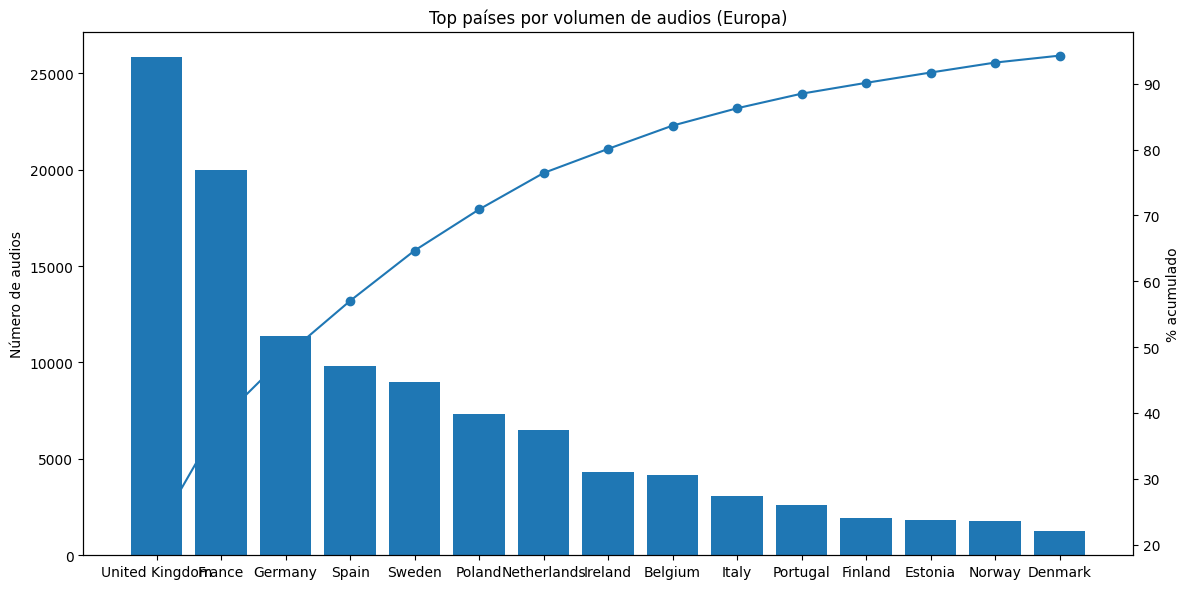

In [209]:
df_country = (
    df_balanced.dropna(subset=["country"])
    .groupby("country")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_audios")
)

df_country["cum_pct"] = df_country["n_audios"].cumsum() / df_country["n_audios"].sum() * 100

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(df_country["country"][:15], df_country["n_audios"][:15])
ax1.set_ylabel("Número de audios")
ax1.set_title("Top países por volumen de audios (Europa)")

ax2 = ax1.twinx()
ax2.plot(df_country["country"][:15], df_country["cum_pct"][:15], marker="o")
ax2.set_ylabel("% acumulado")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 12. Outputs - guardar el dataframe final procesado

In [214]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
REPORTS = PROJECT_ROOT / "reports"

for p in [DATA_RAW, DATA_PROCESSED, REPORTS]:
    p.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT

WindowsPath('c:/Users/anto-/Downloads')